In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from helpers import plot_acf_subplots, plot_acvf_subplots, test_arima, decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
household_power_consumption = pd.read_csv("household_power_consumption.txt", sep=';',
                                                parse_dates={'DateTime' : ['Date', 'Time']}, 
                                                index_col=["DateTime"],
                                                dayfirst=True,
                                                low_memory=False,
                                                na_values=['nan','?'])


In [3]:
household_power_consumption = household_power_consumption[household_power_consumption.index > "2006-12-21"]
household_power_consumption = household_power_consumption[household_power_consumption.index < "2009-12-31"]
household_power_consumption = household_power_consumption.fillna(method="ffill")

In [4]:
household_power_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1592639 entries, 2006-12-21 00:01:00 to 2009-12-30 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1592639 non-null  float64
 1   Global_reactive_power  1592639 non-null  float64
 2   Voltage                1592639 non-null  float64
 3   Global_intensity       1592639 non-null  float64
 4   Sub_metering_1         1592639 non-null  float64
 5   Sub_metering_2         1592639 non-null  float64
 6   Sub_metering_3         1592639 non-null  float64
dtypes: float64(7)
memory usage: 97.2 MB


<Axes: xlabel='DateTime'>

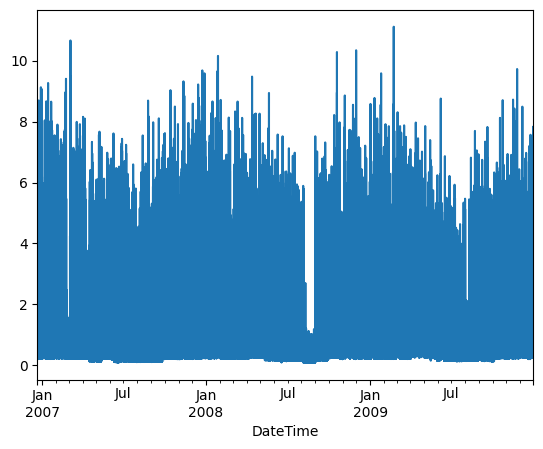

In [5]:
household_power_consumption["Global_active_power"].plot()

## Creating daily weekly monthly and quarterly Dataframes


In [6]:
household_power_consumption = household_power_consumption["Global_active_power"]
household_power_consumption = household_power_consumption.dropna()
daily = household_power_consumption.resample("D").mean()
weekly = household_power_consumption.resample("W").mean()
monthly = household_power_consumption.resample("M").mean()
quarterly = household_power_consumption.resample("3M").mean()

In [7]:
daily = daily.asfreq("D")
weekly = weekly.asfreq("W")
monthly = monthly.asfreq("M")
quarterly = quarterly.asfreq("3M")

[]

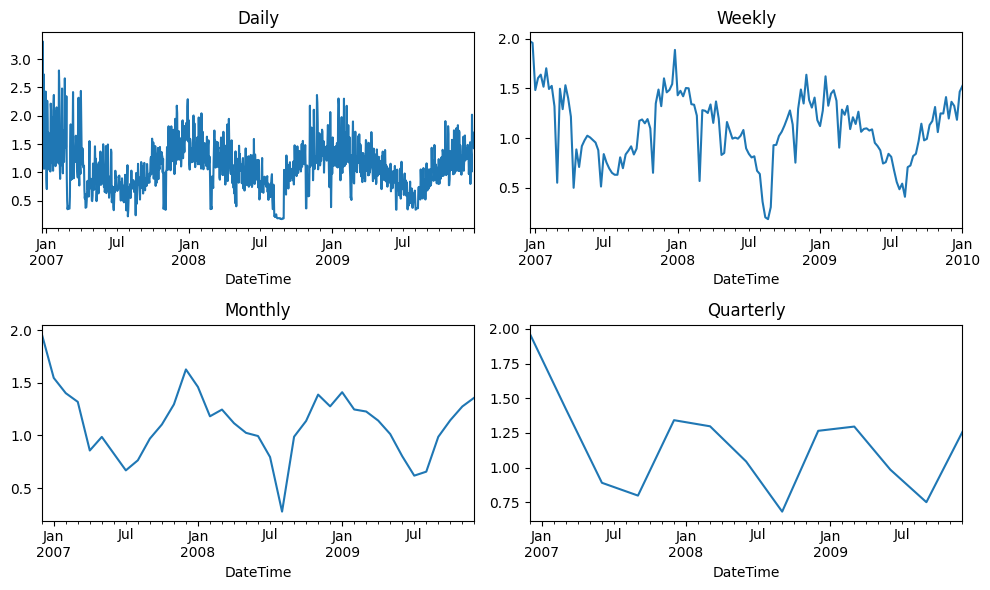

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.savefig("full_series.png")
plt.plot()

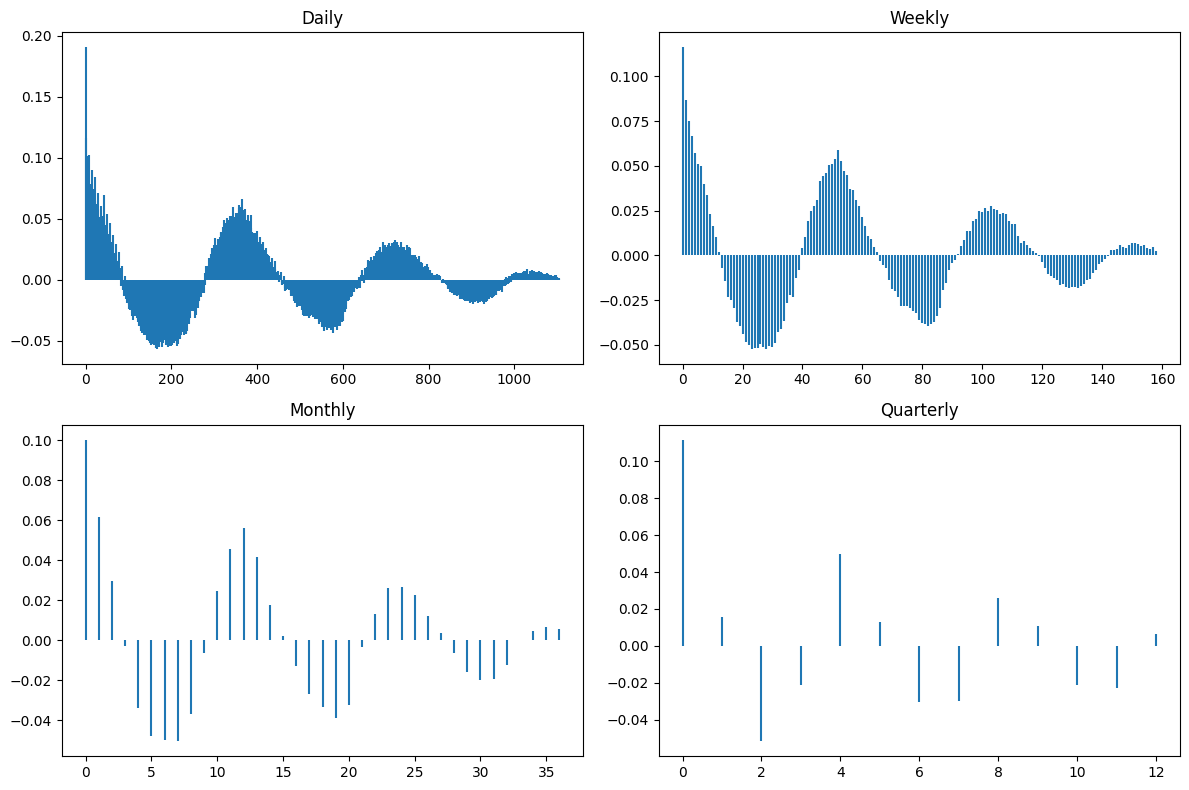

In [9]:
plot_acvf_subplots([daily, weekly, monthly, quarterly], ["Daily", "Weekly", "Monthly", "Quarterly"])

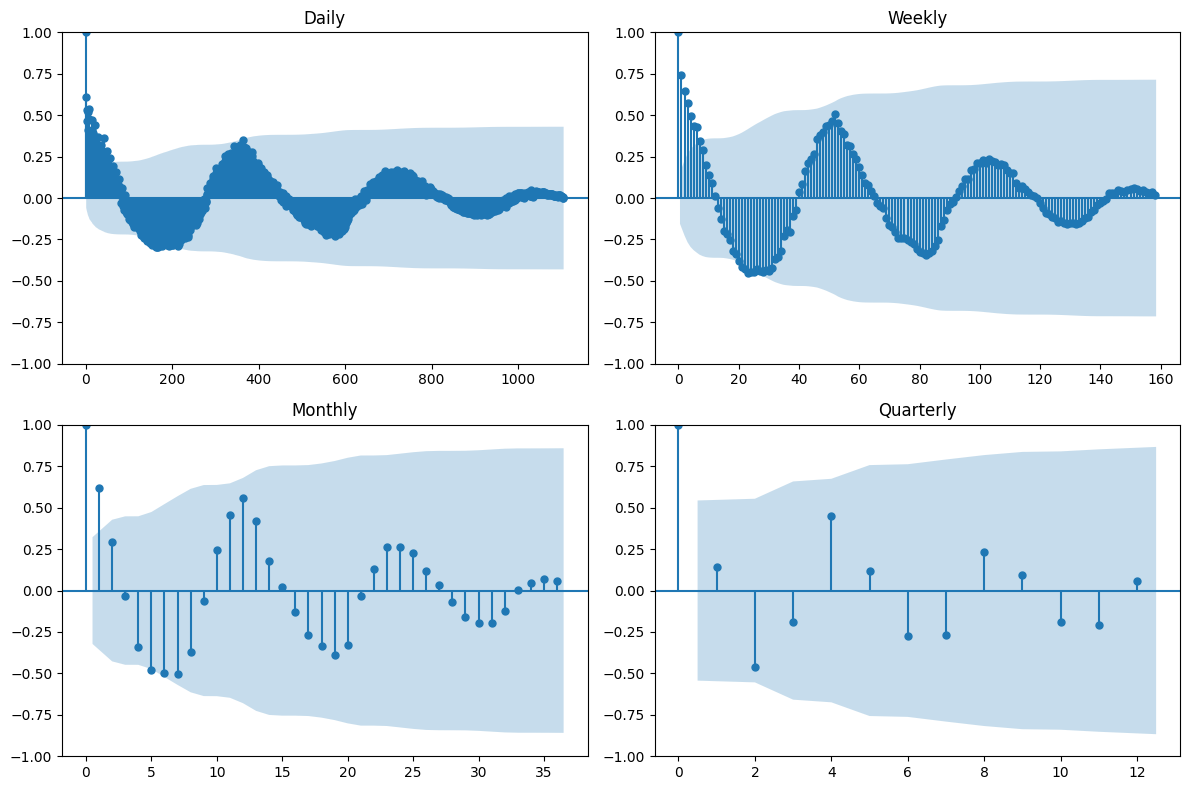

In [10]:
plot_acf_subplots([daily, weekly, monthly, quarterly], ["Daily", "Weekly", "Monthly", "Quarterly"])

## Decompose Trend and Seasonality  

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.177
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


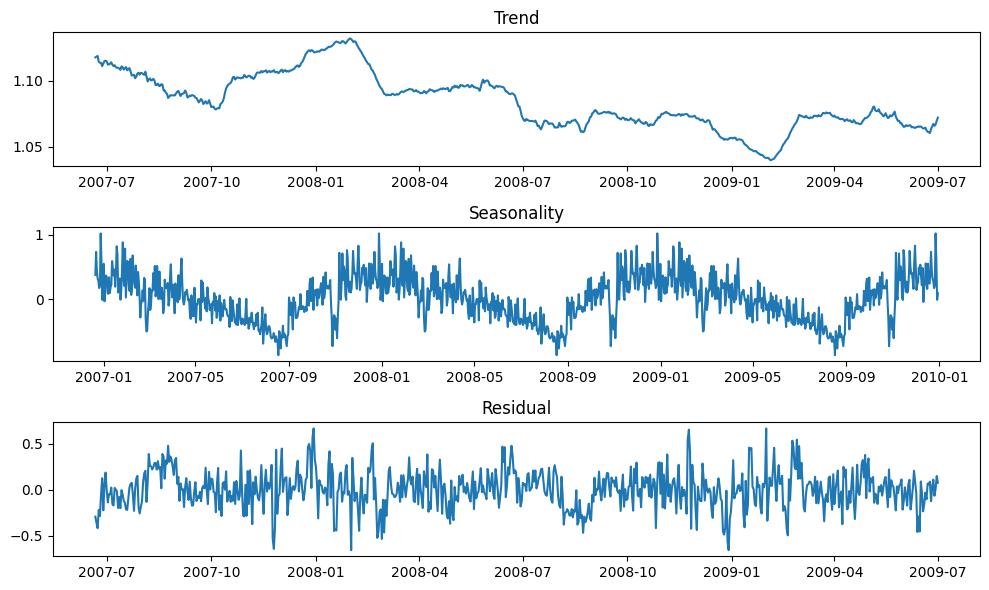

In [11]:
daily_resid = decompose(daily, 365)

In [12]:
len(daily_resid)

742

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.095
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


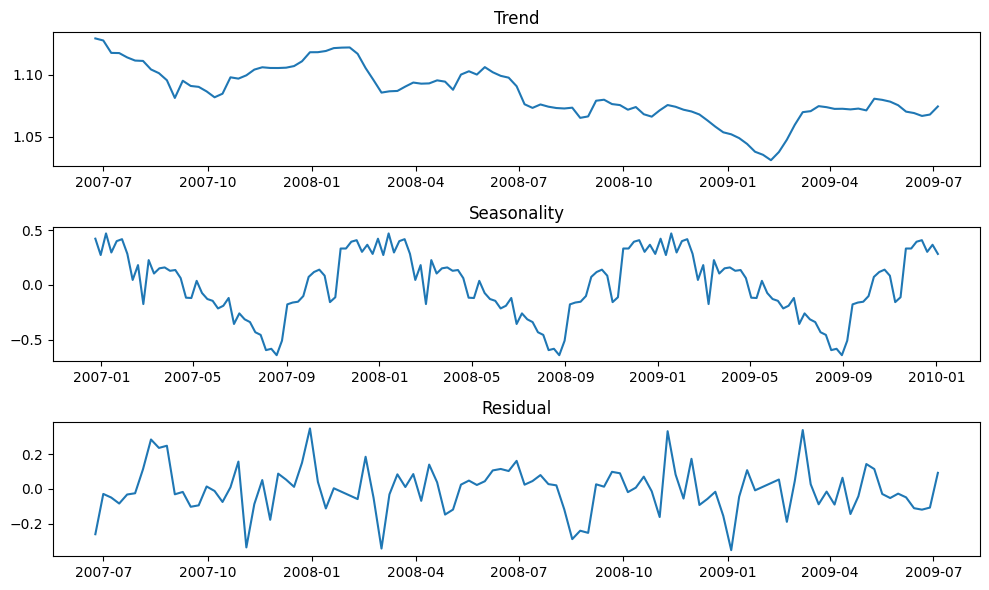

In [13]:
weekly_resid = decompose(weekly, 53)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.572
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.77 (1%), -3.01 (5%), -2.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


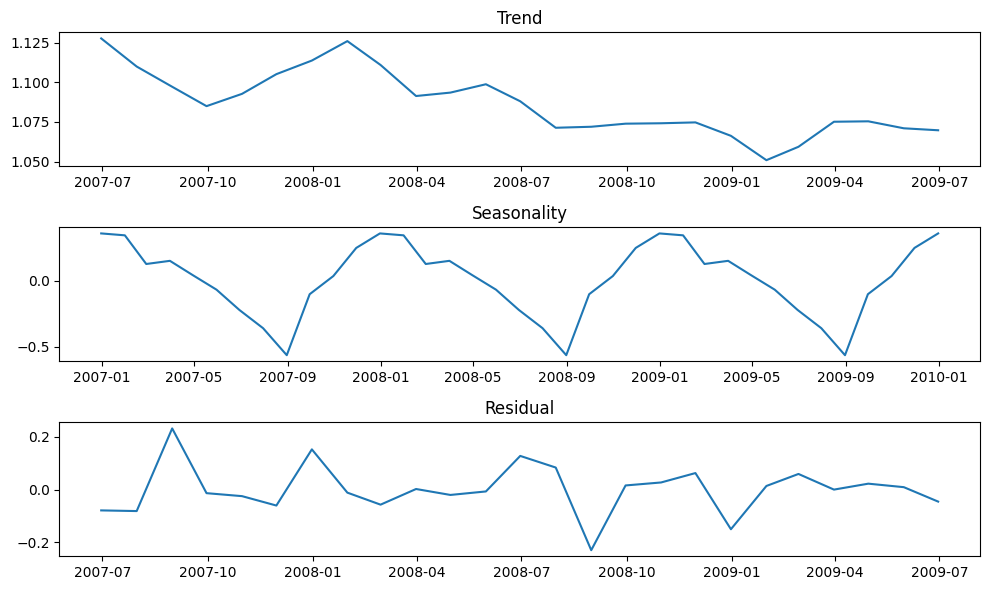

In [14]:
monthly_resid = decompose(monthly, 12)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.394
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -4.67 (1%), -3.37 (5%), -2.80 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


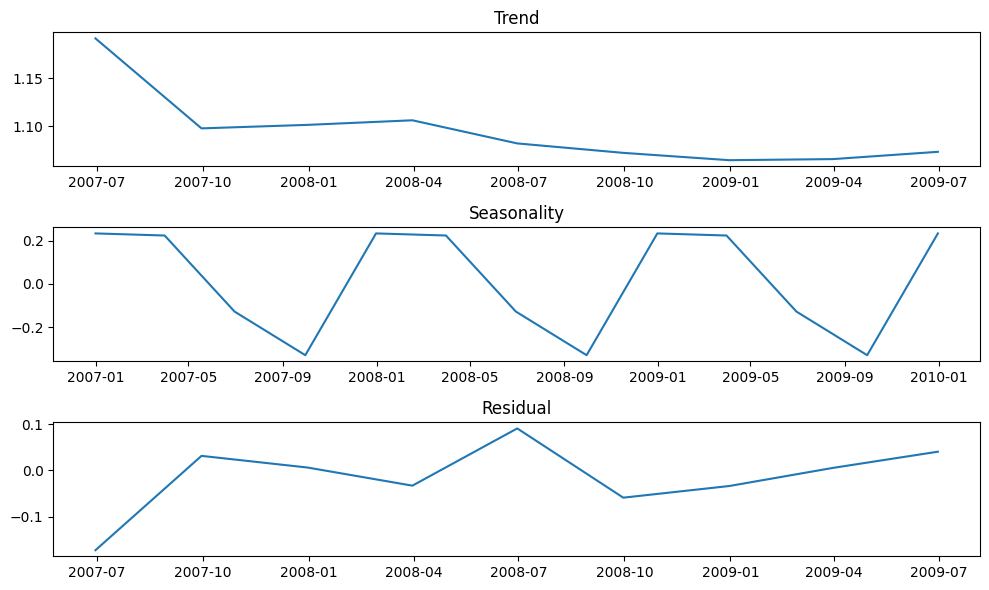

In [15]:
quarterly_resid = decompose(quarterly, 4)

[]

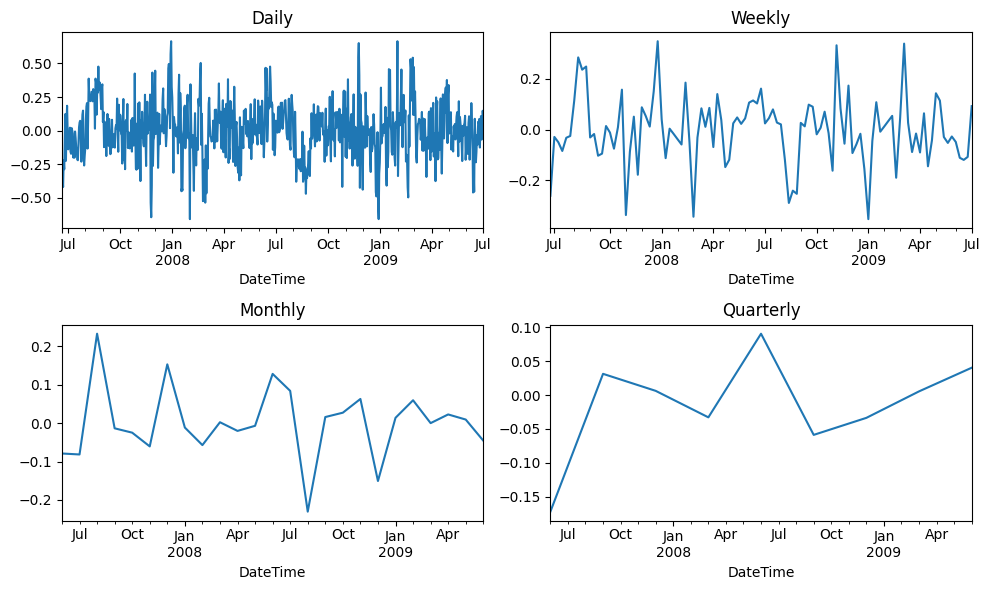

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
daily_resid.plot(y="Global_active_power", ax=axes[0,0], title="Daily")
weekly_resid.plot(y="Global_active_power", ax=axes[0,1], title="Weekly")
monthly_resid.plot(y="Global_active_power", ax=axes[1,0], title="Monthly")
quarterly_resid.plot(y="Global_active_power", ax=axes[1,1], title="Quarterly")
plt.tight_layout()
plt.savefig("resids.png")
plt.plot()

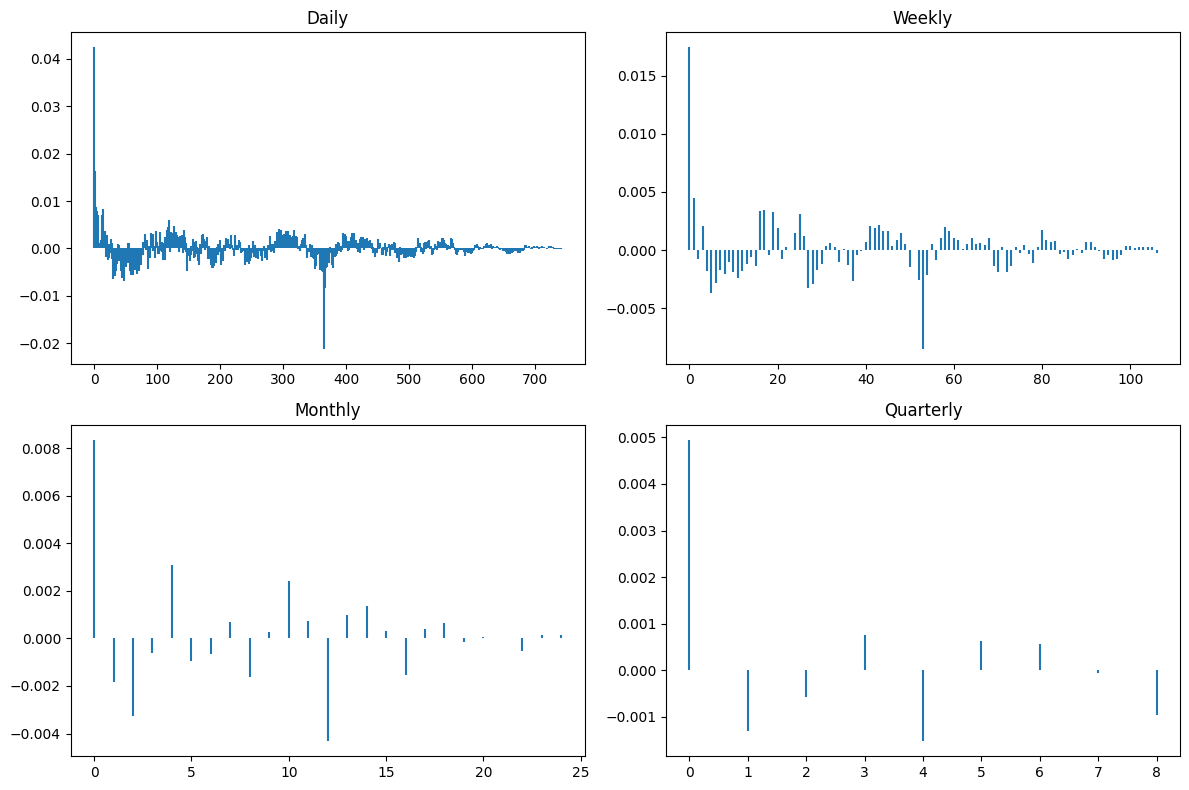

In [17]:
plot_acvf_subplots([daily_resid, weekly_resid, monthly_resid, quarterly_resid], ["Daily", "Weekly", "Monthly", "Quarterly"])

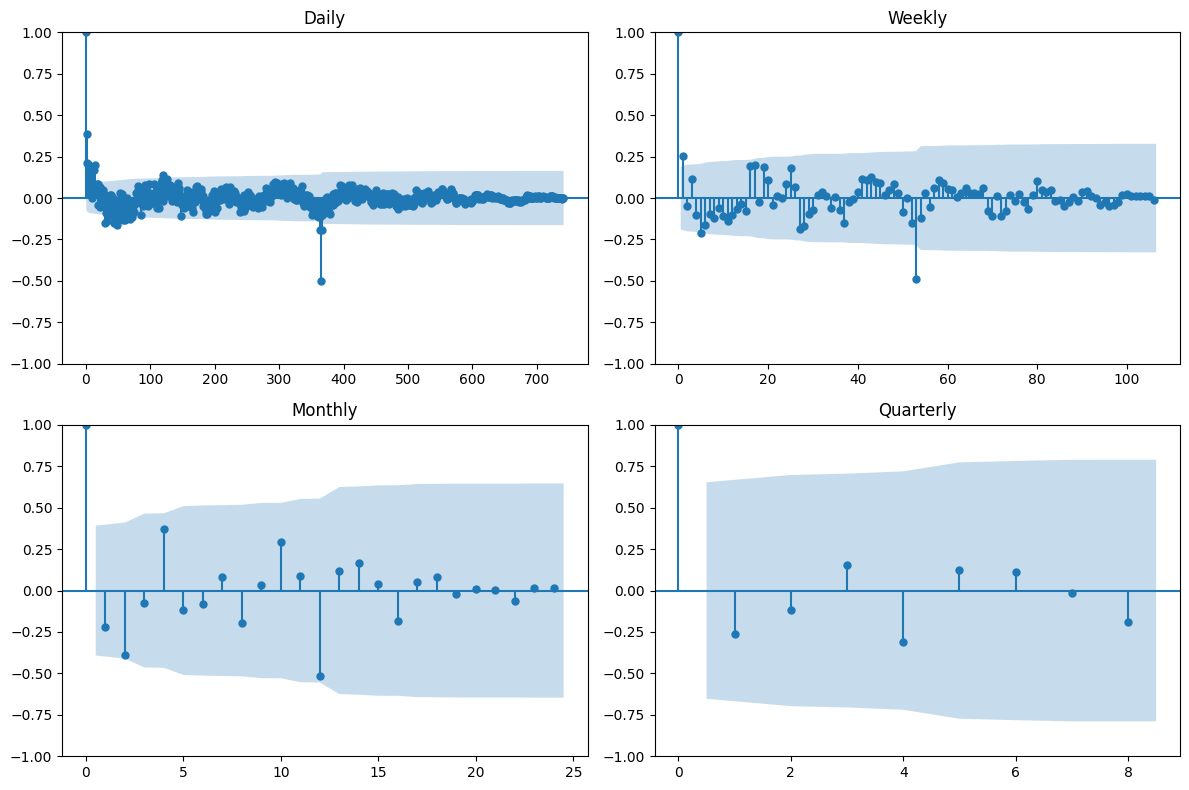

In [18]:
plot_acf_subplots([daily_resid, weekly_resid, monthly_resid, quarterly_resid], ["Daily", "Weekly", "Monthly", "Quarterly"])

In [19]:
print("Best daily ARIMA parameters & AIC:")
test_arima(daily_resid)

Best daily ARIMA parameters & AIC:


((2, 0, 3), -386.12798117913235)

In [20]:
print("Best weekly ARIMA parameters & AIC:")
test_arima(weekly_resid)

Best weekly ARIMA parameters & AIC:


((3, 0, 2), -143.4850205607858)

In [21]:
print("Best monthly ARIMA parameters & AIC:")
test_arima(monthly_resid)

Best monthly ARIMA parameters & AIC:


((3, 0, 0), -51.477503096536445)

In [22]:
print("Best quarterly ARIMA parameters & AIC:")
test_arima(quarterly_resid)

Best quarterly ARIMA parameters & AIC:


((0, 0, 2), -20.718878303845866)

# Quality Model Check 

const     0.006120
ar.L1     1.634055
ar.L2    -0.872990
ma.L1    -1.337815
ma.L2     0.463484
ma.L3     0.278837
sigma2    0.034301
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  742
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 200.064
Date:                Sat, 27 May 2023   AIC                           -386.128
Time:                        11:53:32   BIC                           -353.863
Sample:                    06-21-2007   HQIC                          -373.689
                         - 07-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.012      0.531      0.595      -0

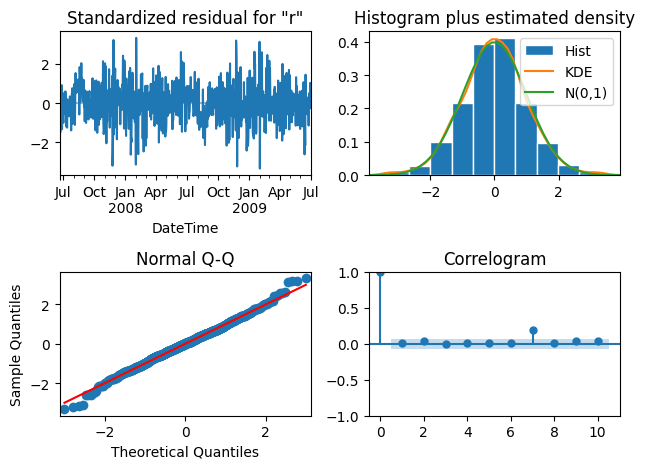

In [23]:
from scipy.stats import shapiro
model = ARIMA(daily_resid, order=(2, 0, 3)).fit()
model.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_daily.png")
print(model.params)
print(model.summary())
print(shapiro(model.standardized_forecasts_error))


const     0.000497
ar.L1     0.355930
ar.L2     0.539344
ar.L3    -0.187281
ma.L1    -0.011021
ma.L2    -0.988618
sigma2    0.012859
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  107
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  78.743
Date:                Sat, 27 May 2023   AIC                           -143.485
Time:                        11:53:33   BIC                           -124.775
Sample:                    06-24-2007   HQIC                          -135.900
                         - 07-05-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.134      0.893      -0

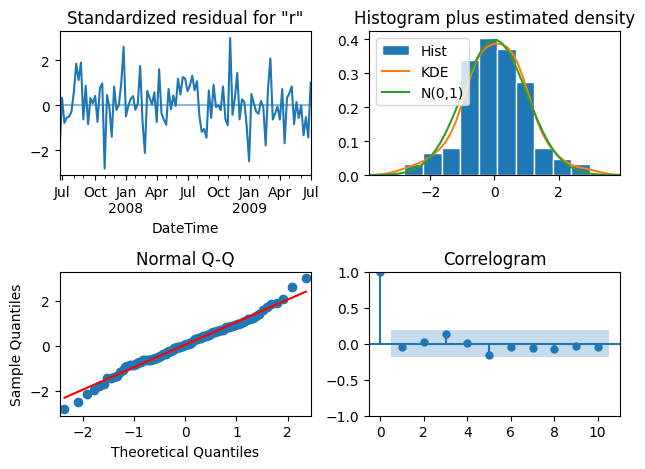

In [24]:
model2 = ARIMA(weekly_resid, order=(3, 0, 2)).fit()
model2.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_weekly.png")
print(model2.params)
print(model2.summary())
print(shapiro(model2.standardized_forecasts_error))

const     0.003771
ar.L1    -0.551572
ar.L2    -0.624531
ar.L3    -0.455055
sigma2    0.004762
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   25
Model:                 ARIMA(3, 0, 0)   Log Likelihood                  30.739
Date:                Sat, 27 May 2023   AIC                            -51.478
Time:                        11:53:33   BIC                            -45.383
Sample:                    06-30-2007   HQIC                           -49.787
                         - 06-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.006      0.585      0.559      -0.009       0.016
ar.L1         -0.5516

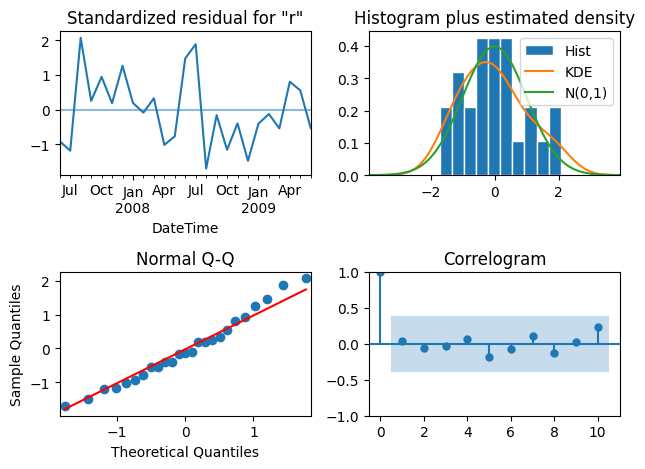

In [25]:
model3 = ARIMA(monthly_resid, order=(3, 0, 0)).fit()
model3.plot_diagnostics()
plt.tight_layout()
plt.savefig("diagnostics_monthly.png")
print(model3.params)
print(model3.summary())
print(shapiro(model3.standardized_forecasts_error))

In [26]:
model4 = ARIMA(quarterly_resid, order=(0, 0, 2)).fit()
print(model4.params)
print(model4.summary())
print(shapiro(model4.standardized_forecasts_error))

const    -0.003926
ma.L1    -1.895947
ma.L2     0.995555
sigma2    0.001279
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                    9
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  14.359
Date:                Sat, 27 May 2023   AIC                            -20.719
Time:                        11:53:34   BIC                            -19.930
Sample:                    06-30-2007   HQIC                           -22.421
                         - 06-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.005     -0.777      0.437      -0.014       0.006
ma.L1         -1.8959    116.721     -0.

## Forecast

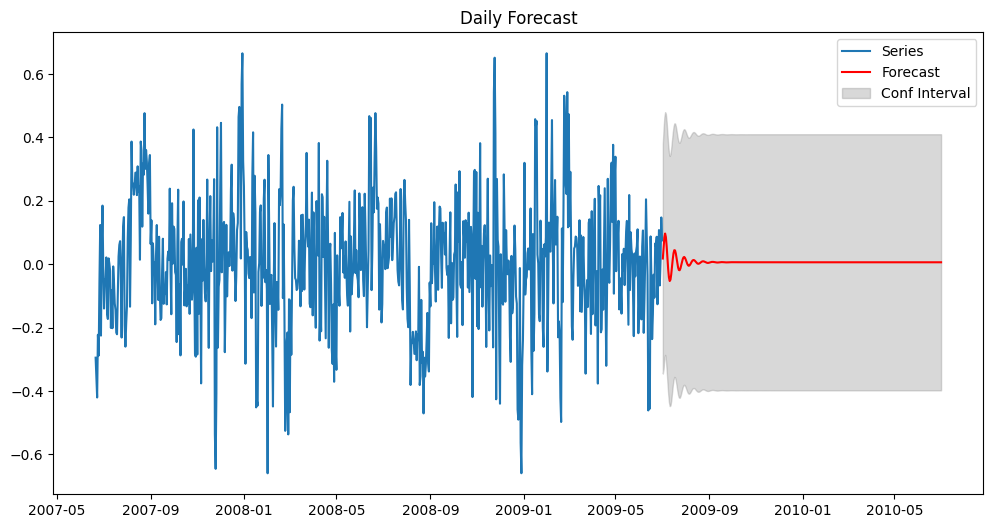

In [31]:
forecast = model.get_forecast(steps=365) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(daily_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.title("Daily Forecast")
plt.show()

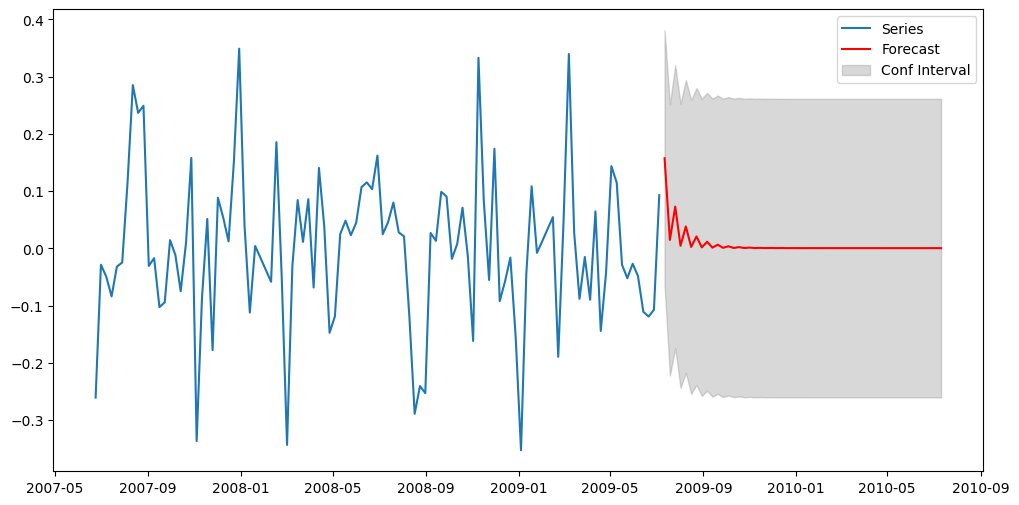

In [28]:
forecast = model2.get_forecast(steps=53) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(weekly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.title("Weekly Forecast")
plt.show()

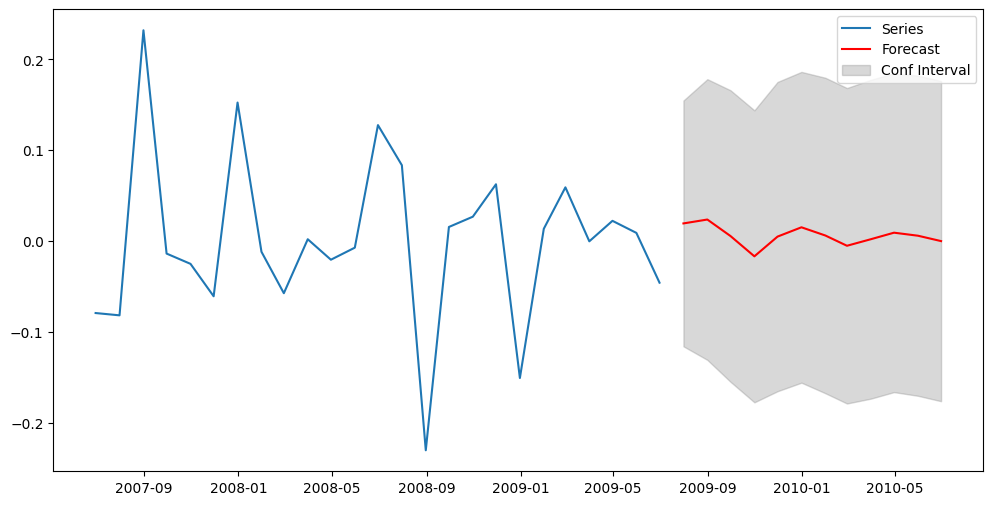

In [29]:
forecast = model3.get_forecast(steps=12) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(monthly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.title("Monthly Forecast")
plt.show()

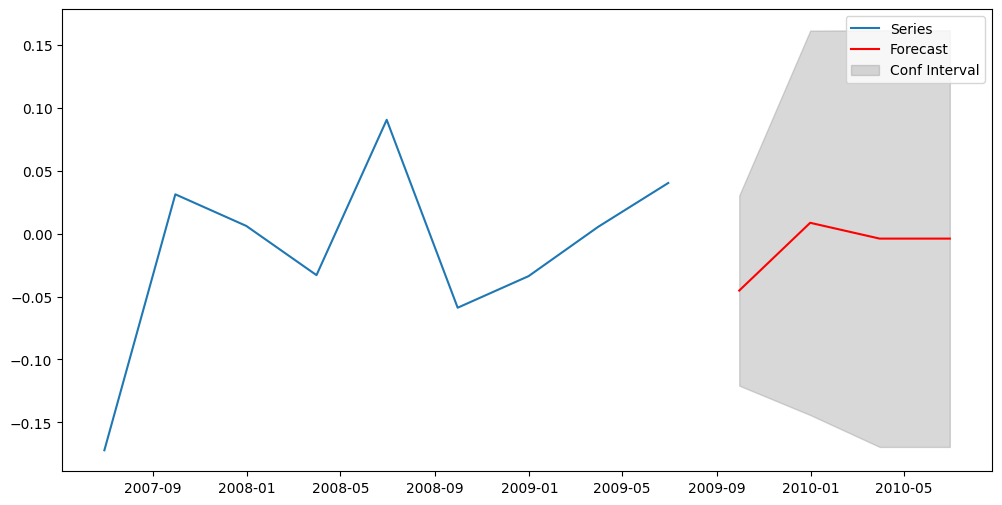

In [30]:
forecast = model4.get_forecast(steps=4) 
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()  
plt.figure(figsize=(12, 6))
plt.plot(quarterly_resid, label='Series')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3, label='Conf Interval')
plt.legend()
plt.title("Quarterly Forecast")
plt.show()